In [1]:
import os
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Dropout, Flatten, Dense, BatchNormalization

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model


from tensorflow.keras.applications.xception import Xception, preprocess_input

In [2]:
img_width=256; img_height=256
batch_size=8
TRAINING_DIR = '../weather_pred/Data/training/'
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=30,
                                   zoom_range=0.4,
                                   horizontal_flip=True
                                   )
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    target_size=(img_height, img_width))

Found 1274 images belonging to 5 classes.


In [3]:
VALIDATION_DIR = '../weather_pred/Data/validation/'

validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=batch_size,
                                                              class_mode='categorical',
                                                              target_size=(img_height, img_width)
                                                             )

Found 226 images belonging to 5 classes.


In [4]:
callbacks = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')        
# autosave best Model
best_model_file = '../xception_drop_batch_best_weights_256.h5'
best_model = ModelCheckpoint(best_model_file, monitor='val_acc', verbose = 1, save_best_only = True) 


In [6]:
xception_base = Xception(include_top=False, weights='imagenet',
                           input_tensor=None, input_shape=(img_height, img_width,3))

83697664/83683744 [==============================] - 26s 0us/step


In [8]:
print('Adding new layers...')
output = xception_base.get_layer(index = -1).output  
output = Flatten()(output)
# let's add a fully-connected layer
output = Dense(512,activation = "relu")(output)
output = BatchNormalization()(output)
output = Dropout(0.2)(output)
output = Dense(512,activation = "relu")(output)
output = BatchNormalization()(output)
output = Dropout(0.2)(output)
# and a logistic layer -- let's say we have 4 classes
output = Dense(5, activation='softmax')(output)
print('New layers added!')

Adding new layers...
New layers added!


In [9]:
xception_model = Model(xception_base.input, output)
for layer in xception_model.layers[:-7]:
    layer.trainable = False

xception_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 127, 127, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 127, 127, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

 block4_sepconv1_bn (BatchNorma  (None, 32, 32, 728)  2912       ['block4_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block4_sepconv2_act (Activatio  (None, 32, 32, 728)  0          ['block4_sepconv1_bn[0][0]']     
 n)                                                                                               
                                                                                                  
 block4_sepconv2 (SeparableConv  (None, 32, 32, 728)  536536     ['block4_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block4_sepconv2_bn (BatchNorma  (None, 32, 32, 728)  2912       ['block4_sepconv2[0][0]']        
 lization)

 n)                                                                                               
                                                                                                  
 block7_sepconv1 (SeparableConv  (None, 16, 16, 728)  536536     ['block7_sepconv1_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block7_sepconv1_bn (BatchNorma  (None, 16, 16, 728)  2912       ['block7_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block7_sepconv2_act (Activatio  (None, 16, 16, 728)  0          ['block7_sepconv1_bn[0][0]']     
 n)                                                                                               
          

 block9_sepconv3_bn (BatchNorma  (None, 16, 16, 728)  2912       ['block9_sepconv3[0][0]']        
 lization)                                                                                        
                                                                                                  
 add_7 (Add)                    (None, 16, 16, 728)  0           ['block9_sepconv3_bn[0][0]',     
                                                                  'add_6[0][0]']                  
                                                                                                  
 block10_sepconv1_act (Activati  (None, 16, 16, 728)  0          ['add_7[0][0]']                  
 on)                                                                                              
                                                                                                  
 block10_sepconv1 (SeparableCon  (None, 16, 16, 728)  536536     ['block10_sepconv1_act[0][0]']   
 v2D)     

                                                                                                  
 block12_sepconv3_act (Activati  (None, 16, 16, 728)  0          ['block12_sepconv2_bn[0][0]']    
 on)                                                                                              
                                                                                                  
 block12_sepconv3 (SeparableCon  (None, 16, 16, 728)  536536     ['block12_sepconv3_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block12_sepconv3_bn (BatchNorm  (None, 16, 16, 728)  2912       ['block12_sepconv3[0][0]']       
 alization)                                                                                       
                                                                                                  
 add_10 (A

In [10]:
xception_model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics =['accuracy'])
history = xception_model.fit_generator(train_generator,
                              epochs=30,
                              verbose=1,
                              validation_data=validation_generator,
                              callbacks = [callbacks, best_model]
                              )

C:\Users\Kerillos\AppData\Local\Temp\ipykernel_11816\1483601860.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = xception_model.fit_generator(train_generator,


Epoch 1/30
160/160 [==============================] - 29s 148ms/step - loss: 0.9198 - accuracy: 0.7017 - val_loss: 0.5034 - val_accuracy: 0.8451
Epoch 2/30
160/160 [==============================] - 20s 123ms/step - loss: 0.7548 - accuracy: 0.7622 - val_loss: 0.3678 - val_accuracy: 0.8850
Epoch 3/30
160/160 [==============================] - 19s 121ms/step - loss: 0.4778 - accuracy: 0.8532 - val_loss: 1.0838 - val_accuracy: 0.7434
Epoch 4/30
160/160 [==============================] - 20s 122ms/step - loss: 0.4922 - accuracy: 0.8281 - val_loss: 0.3185 - val_accuracy: 0.9027
Epoch 5/30
160/160 [==============================] - 18s 114ms/step - loss: 0.4237 - accuracy: 0.8540 - val_loss: 0.2792 - val_accuracy: 0.9292
Epoch 6/30
160/160 [==============================] - 21s 130ms/step - loss: 0.4462 - accuracy: 0.8485 - val_loss: 0.1976 - val_accuracy: 0.9292
Epoch 7/30
160/160 [==============================] - 23s 141ms/step - loss: 0.4211 - accuracy: 0.8556 - val_loss: 0.2221 - val_ac

In [12]:
target_dir = '../weather_pred/' 
if not os.path.exists(target_dir):
  os.mkdir(target_dir)
xception_model.save(target_dir + 'xception_model_256.h5')
xception_model.save_weights(target_dir + 'xception_weights_256.h5')

In [13]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(len(acc))

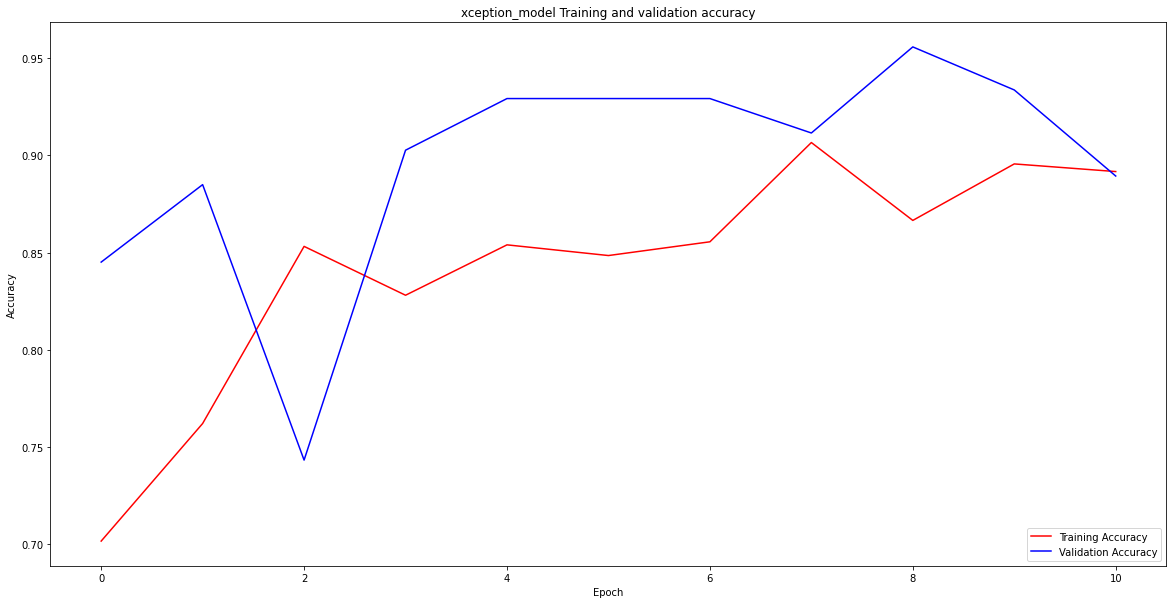

In [14]:
fig = plt.figure(figsize=(20,10))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('xception_model Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()
fig.savefig('Accuracy_curve_xception_model.jpg')

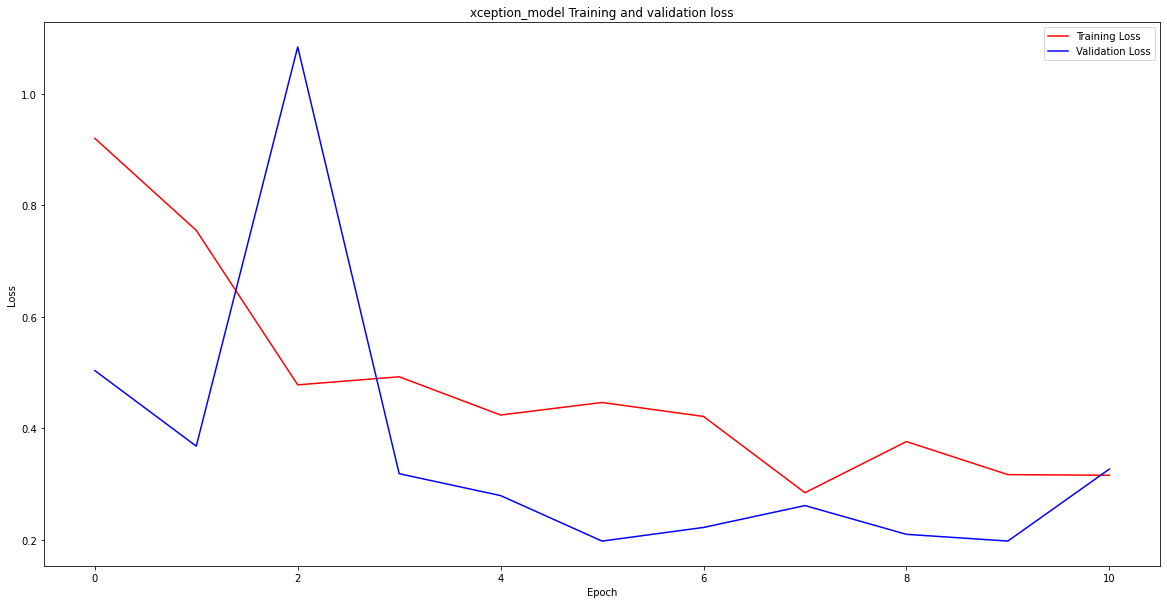

In [15]:
fig2 = plt.figure(figsize=(20,10))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('xception_model Training and validation loss')
fig2.savefig('Loss_curve_xception_model.jpg')

In [16]:
import numpy as np
test_preprocessed_images = np.load('../test_preproc_res-net.npy')


In [17]:
#Prediction Function
array = xception_model.predict(test_preprocessed_images, batch_size=1, verbose=1)
y_pred = np.argmax(array, axis=1)

30/30 [==============================] - 2s 10ms/step


In [18]:
import pandas as pd
test_df = pd.read_csv('../dataset/test.csv')
y_true = test_df['labels']

In [19]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_true, y_pred)


In [20]:
train_dir = '../weather_pred/Data/training/'
classes = os.listdir(train_dir)

In [21]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = cm.round(2)
        
    else:
        cm=cm
        
    

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

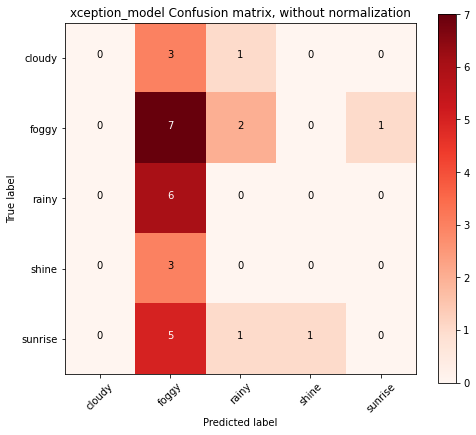

In [22]:
np.set_printoptions(precision=2)

fig1 = plt.figure(figsize=(7,6))
plot_confusion_matrix(conf_mat, classes=classes, title='xception_model Confusion matrix, without normalization')
plt.show()

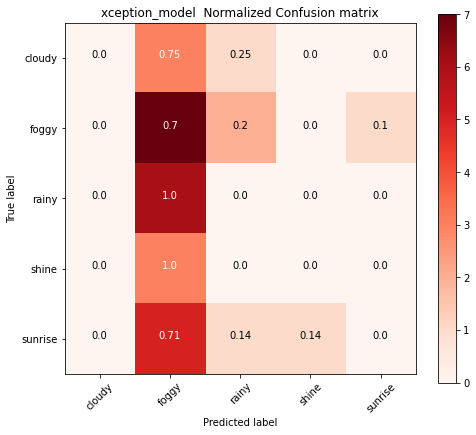

In [23]:
np.set_printoptions(precision=2)

fig2 = plt.figure(figsize=(7,6))
plot_confusion_matrix(conf_mat, classes=classes, normalize = True, title='xception_model  Normalized Confusion matrix')
fig2.savefig('../cm_norm.jpg')
plt.show()

In [24]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=classes))


              precision    recall  f1-score   support

      cloudy       0.00      0.00      0.00         4
       foggy       0.29      0.70      0.41        10
       rainy       0.00      0.00      0.00         6
       shine       0.00      0.00      0.00         3
     sunrise       0.00      0.00      0.00         7

    accuracy                           0.23        30
   macro avg       0.06      0.14      0.08        30
weighted avg       0.10      0.23      0.14        30



C:\Users\Kerillos\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Kerillos\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Kerillos\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
from sklearn.metrics import accuracy_score
accuracy_score(y_true, y_pred)

0.23333333333333334